In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lkkcp\anaconda3\envs\tf7\lib\site-packages\tensorflow\python\framework

In [5]:
import importlib
importlib.reload(readcsv1)
### forsome reason it doesn't autoreload the python files

<module 'readcsv1' from 'C:\\Users\\lkkcp\\Desktop\\NeuralNetwork\\ECE247-project-main\\readcsv1.py'>

In [6]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [30]:
## get data, just Close values
#importlib.reload(readcsv1)
import readcsv1
fulldata = readcsv1.get_data(start = '1997-01-17',verbose=True,normalize=True).astype(np.float32)
print(fulldata.shape)

0 Data/000-EuroPerDollar(USDEUR).csv Close
1 Data/000-EuroPerDollar(USDEUR).csv Open
2 Data/000-EuroPerDollar(USDEUR).csv High
3 Data/000-EuroPerDollar(USDEUR).csv Low
4 Data/Bond-Germany2-yearNoteYield(IGDEU2D).csv Close
5 Data/Bond-Germany9-yearNoteYield(IGDEU9D).csv Close
6 Data/Bond-MoodyBAA(MOCBAAD).csv Close
7 Data/Bond-US10-yearBondYield(IGUSA10D).csv Close
8 Data/Bond-US2-yearNoteYield(IGUSA2D).csv Close
9 Data/Commod-GoldPrice(__XAU_D).csv Close
10 Data/Commod-GoldPrice(__XAU_D).csv Open
11 Data/Commod-GoldPrice(__XAU_D).csv High
12 Data/Commod-GoldPrice(__XAU_D).csv Low
13 Data/Commod-OilPrice(__WTC_D).csv Close
14 Data/Commod-OilPrice(__WTC_D).csv Open
15 Data/Commod-OilPrice(__WTC_D).csv High
16 Data/Commod-OilPrice(__WTC_D).csv Low
17 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Close
18 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Open
19 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv High
20 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Low
21 Data/Commod-ReutersCRBIndustrialRaw(CMCRBI

In [31]:
## indicators to use when training

smalllist =[0,1,2,3]
#data = fulldata[:,keeplist]
data = fulldata[:,smalllist]
data.shape

(8750, 4)

# First trial, the data is just Open Close High Low of US-Euro Exchange rate

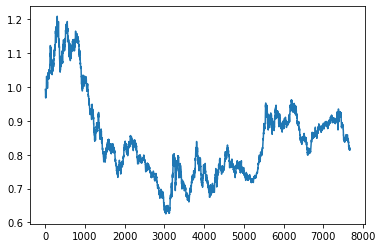

In [29]:
## visualize data
plt.plot(data[:, 0])
plt.show()

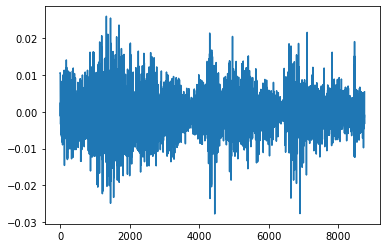

Some examples of differences [ 0.01060003  0.01060003  0.01060003  0.00559998  0.00310004  0.00730002
  0.00220001 -0.00120002 -0.00120002 -0.00120002  0.0025     -0.0007
 -0.00339997 -0.0029      0.00239998  0.00239998  0.00239998 -0.00099999
  0.00260001 -0.00190002]
Some examples of the labels [ True  True  True  True  True  True  True False False False  True False
 False False  True  True  True False  True False]
0.4850285714285714 fraction of data has positive difference
0.5149714285714286 fraction of data has difference <= 0 


In [43]:
## Just predict if the price difference is >0 or not. 

diff = data[:,0]-data[:,1]  # close minus open
plt.plot(diff)   ##The differences are zero before year 1997-01-17
plt.show()
y = diff > 0

print('Some examples of differences', diff[0:20])
print('Some examples of the labels', y[0:20])

print(np.count_nonzero(y)/y.size, 'fraction of data has positive difference')
print(1-np.count_nonzero(y)/y.size, 'fraction of data has difference <= 0 ')

In [44]:
def generate_batches(data, label, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X_batch: shape = (B, len(learn_window), C)
    - y_batch: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    num_classes = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window,:]
        y[k] = label[i+Lcap+predict_window] 
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data, y, 7, np.arange(50), np.arange(1))

X_batch, y_batch = next(G)
print(X_batch.shape)
print(y_batch.shape)

(7, 50, 4)
(7, 1)


In [45]:
## split into training, validation, and testing sets
data_train = data[:-1500, :]
y_train = y[:-1500]
data_val = data[-1500:-500, :]
y_val=y[-1500:-500]
data_test = data[-500:,:]
y_test = y[-500:]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)
print("Validation:", data_val.shape)

Training: (7250, 4)
Testing: (500, 4)
Validation: (1000, 4)


In [70]:
## ===== model hyperparameters ======================
learn_window = np.arange(40)    ## learn from past 40 days, which is two month. 
predict_window = np.arange(1)   ## predict next day

batch_size = 50
initial_learning_rate = 1e-4   
decay_steps = 300
decay_rate = 0.9
L1reg = 0.001
L2reg = 0.001
drop_prob = 0.2

## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_1d = models.Sequential()
model_1d.add(layers.GRU(100, input_shape=(L, C)))
model_1d.add(layers.Dense(2, kernel_regularizer = keras.regularizers.l2(L2reg), activation='softmax')) #2 output categories
model_1d.compile(optimizer=opt, loss=keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
model_1d.summary()

## Add dropout?
## Add regularization? 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 100)               31500     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 31,702
Trainable params: 31,702
Non-trainable params: 0
_________________________________________________________________


In [71]:
#### Before training, let's see what the model would predict for validation data
## generate validation data
G = generate_batches(data_val, y_val, 200, learn_window, predict_window)
X_val_batch, y_val_batch = next(G)

np.argmax(model_1d.predict(X_val_batch),axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [72]:
## train
G = generate_batches(data_train, y_train, batch_size, learn_window, predict_window)

model_1d.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_val_batch, y_val_batch))

Epoch 1/10
300/300 [==============================] - 22s 74ms/step - loss: 0.6971 - acc: 0.4899 - val_loss: 0.6946 - val_acc: 0.5500
Epoch 2/10
300/300 [==============================] - 20s 66ms/step - loss: 0.6971 - acc: 0.4948 - val_loss: 0.6951 - val_acc: 0.5500
Epoch 3/10
300/300 [==============================] - 20s 67ms/step - loss: 0.6965 - acc: 0.5076 - val_loss: 0.6940 - val_acc: 0.5500
Epoch 4/10
300/300 [==============================] - 21s 68ms/step - loss: 0.6966 - acc: 0.4941 - val_loss: 0.6952 - val_acc: 0.5500
Epoch 5/10
300/300 [==============================] - 21s 69ms/step - loss: 0.6964 - acc: 0.5042 - val_loss: 0.6963 - val_acc: 0.4850
Epoch 6/10
300/300 [==============================] - 25s 83ms/step - loss: 0.6960 - acc: 0.5073 - val_loss: 0.6965 - val_acc: 0.4500
Epoch 7/10
300/300 [==============================] - 23s 78ms/step - loss: 0.6958 - acc: 0.5131 - val_loss: 0.6933 - val_acc: 0.5500
Epoch 8/10
300/300 [==============================] - 26s 85ms

In [73]:
print('Lets see what the model is predicting for the validation data set')
np.argmax(model_1d.predict(X_val_batch),axis=1)

Lets see what the model is predicting for the validation data set


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

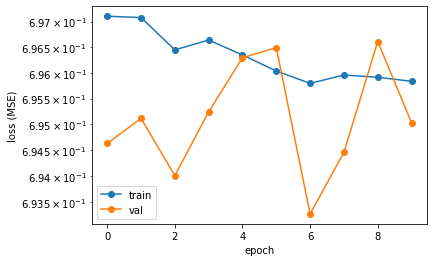

In [74]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

# Now use 35 of all the data, which are most of the daily datas.

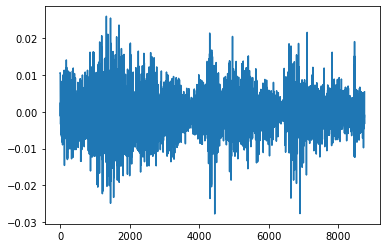

Some examples of differences [ 0.01060003  0.01060003  0.01060003  0.00559998  0.00310004  0.00730002
  0.00220001 -0.00120002 -0.00120002 -0.00120002  0.0025     -0.0007
 -0.00339997 -0.0029      0.00239998  0.00239998  0.00239998 -0.00099999
  0.00260001 -0.00190002]
Some examples of the labels [ 1  1  1  1  1  1  1  0  0  0  1  0 -1 -1  1  1  1  0  1 -1]
0.34685714285714286 fraction of data has z>boundary
0.35005714285714284 fraction of data has z<boundary


In [41]:
## Prediction is the closing-opening price of next day. 
## There are three categories: very positive, neglible, very negative, corresponding to class 2,0,1, respectively. 
## The classifation depends on the data's "Z score". 
## It's not the actual Z score because we only take (opening-closing)/std, so that the signs are conserved. 
## The boundary Z score is a hyperparameter that should be tuned.

boundary = 0.3   #Tunable hyperparameter. Right now roughly 1/3 of the data have Z>0.3

diff = data[:,0]-data[:,1]

#visualize the difference
plt.plot(diff)   ##The differences are zero before year 1997-01-17
plt.show()

y = np.zeros_like(diff)
#mu = diff.mean()
sigma = diff.std()
z_scores = diff/sigma
y[z_scores > boundary] = 1
y[z_scores < -boundary] = -1
y = y.astype(np.int8)

print('Some examples of differences', diff[0:20])
print('Some examples of the labels', y[0:20])

print(np.count_nonzero(z_scores > boundary)/y.size, 'fraction of data has z>boundary')
print(np.count_nonzero(z_scores < -boundary)/y.size, 'fraction of data has z<boundary')

In [ ]:
keeplist = [0,1,2,3,4,5,7,8,27,28,29,30,31,32,33,34,35,36,62,63,64,65,66,67,68,69,70,71,72,73,82,83,84,85,86]
data = fulldata[:,keeplist]

In [38]:
def generate_batches(data, label, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X: shape = (B, len(learn_window), C)
    - y: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    num_classes = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window,:]
        y[k] = label[i+Lcap+predict_window] 
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data, y, 7, np.arange(50), np.arange(1))

X_batch, y_batch = next(G)
print(X_batch.shape)
print(y_batch.shape)

(7, 50, 4)
(7, 1)


In [184]:
## split into training, validation, and testing sets
data_train = data[:-1500, :]
y_train = y[:-1500]
data_val = data[-1500:-500, :]
y_val=y[-1500:-500]
data_test = data[-500:,:]
y_test = y[-500:]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)
print("Validation:", data_val.shape)

Training: (6171, 35)
Testing: (500, 35)
Validation: (1000, 35)


In [265]:
## ===== model hyperparameters ======================
learn_window = np.arange(40)    ## learn from past 40 days, which is two month. 
predict_window = np.arange(1)   ## predict next day

batch_size = 50
initial_learning_rate = 1e-4    
decay_steps = 300
decay_rate = 0.9
L1reg = 0.001
L2reg = 0.001
drop_prob = 0.2

## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_1d = models.Sequential()
model_1d.add(layers.GRU(100, input_shape=(L, C), kernel_regularizer=keras.regularizers.l1(L1reg),return_sequences=True,dropout=drop_prob))
model_1d.add(layers.GRU(100, kernel_regularizer = keras.regularizers.l1(L1reg),return_sequences=True,dropout=drop_prob))
model_1d.add(layers.GRU(50, kernel_regularizer = keras.regularizers.l2(L2reg)))
model_1d.add(layers.Dense(3, kernel_regularizer = keras.regularizers.l2(L2reg), activation='softmax')) #3 output categories
model_1d.compile(optimizer=opt, loss=keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
model_1d.summary()

## Add dropout?
## Add regularization? 

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_51 (GRU)                 (None, 40, 100)           40800     
_________________________________________________________________
gru_52 (GRU)                 (None, 40, 100)           60300     
_________________________________________________________________
gru_53 (GRU)                 (None, 50)                22650     
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 153       
Total params: 123,903
Trainable params: 123,903
Non-trainable params: 0
_________________________________________________________________


In [258]:
## generate test data
G = generate_batches(data_val, y_val, 100, learn_window, predict_window)
X_val_batch, y_val_batch = next(G)

In [144]:
## train on one data point as test
G = generate_batches(data_train, y_train, 1, learn_window, predict_window)
X_train_batch, y_train_batch = next(G)

model_1d.fit(X_train_batch, y_train_batch, batch_size=1)
model_1d.evaluate(X_train_batch, y_train_batch, batch_size=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1/1 [==============================] - 0s 232ms/sample - loss: 0.0577 - acc: 1.0000


[0.057696934789419174, 1.0]

In [266]:
## train!
G = generate_batches(data_train, y_train, batch_size, learn_window, predict_window)

model_1d.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_val_batch, y_val_batch))

Epoch 1/10
300/300 [==============================] - 76s 253ms/step - loss: 3.3540 - acc: 0.3784 - val_loss: 3.0040 - val_acc: 0.3400
Epoch 2/10
300/300 [==============================] - 73s 243ms/step - loss: 2.6834 - acc: 0.3791 - val_loss: 2.4569 - val_acc: 0.3400
Epoch 3/10
300/300 [==============================] - 79s 265ms/step - loss: 2.2200 - acc: 0.3964 - val_loss: 2.0670 - val_acc: 0.3500
Epoch 4/10
300/300 [==============================] - 82s 274ms/step - loss: 1.9185 - acc: 0.3977 - val_loss: 1.8438 - val_acc: 0.3500
Epoch 5/10
300/300 [==============================] - 89s 298ms/step - loss: 1.7394 - acc: 0.3902 - val_loss: 1.7389 - val_acc: 0.3400
Epoch 6/10
300/300 [==============================] - 84s 279ms/step - loss: 1.6494 - acc: 0.3954 - val_loss: 1.6871 - val_acc: 0.3400
Epoch 7/10
300/300 [==============================] - 83s 276ms/step - loss: 1.6051 - acc: 0.3870 - val_loss: 1.6320 - val_acc: 0.3400
Epoch 8/10
300/300 [==============================] - 8

comment: it looks like validation loss is less than training loss. This is actually due to the fact that the training data is just harder to model than the testing data. This is not a bug, since if I validate on the testing data I get roughly similar losses. At least, this assures us that our model is not overfitting. Also, the training loss is a running average over the epoch, so is over-estimated in the beginning.

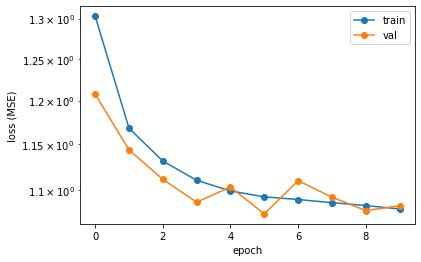

In [193]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [267]:
## See what the model is predicting for the validation data
N, C = data_val.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap # ceiling for i
X_learn = np.zeros((M, L, C))
for i in range(M):
    X_learn[i] = data_val[i+learn_window]
pred = np.argmax(model_1d.predict(X_learn),axis=1)

In [268]:
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Keep getting models that just predict one single category....

In [251]:
###  Compare trading using the predicted values versus just adding close-open.
print('Trading according to prediction, one makes')
print(np.sum(diff[-1500+Lcap+1:-500][pred==2])-np.sum(diff[-1500+Lcap+1:-500][pred==1]))
print('Trading everyday with close-open price difference, one makes')
print(np.sum(diff[-1500+Lcap+1:-500]))
print('Trading optimally, one would make')
print(np.sum(diff[-1500:-500][y_val==2])-np.sum(diff[-1500:-500][y_val==1]))

Trading according to prediction, one makes
-0.085601985
Trading everyday with close-open price difference, one makes
0.16300136
Trading optimally, one would make
2.617801
